### This model is used to do model comparison on four Dark Matter density profiles. The model compared 4 density files: NFW profile,  Isothermal profile, Einasto profile and Generalized DM profile.

This tutorial gives an exmple of the calculation of NFW file. The calculations for other files are contained in model0425.ipynb



### The four Dark Matter density profiles models: 

Note that

r: galactocentric radius

$ \rho( r ) $ : Dark Matter Density as a function of galactocentric radius


### (1) NFW profile :

 $ \rho \left( r \right) \propto \frac{1}{{\left( r/a \right)}{\left[ 1~+~{{\left( r/a \right)}} \right]}^{2}} $

### We can calcuate rotational curve from Dark Matter density profiles, by assuming dark matter distribution is spherically symmetric

$ \frac{GMm}{4 \pi  R^2} = \frac {m v^2}{R}$  where $M=\int_{R_o}^{R} \rho (r) 4 \pi  R^2 dr$

$v_{calculated} = \sqrt { \frac{ G   \int_{R_o}^{R} \rho (r) 4 \pi  r^2 dr} {4 \pi  r}  }   $



### Model

Model 

$ M $ = The rotational curve calculated with the existence of dark matter and the dark matter density is given by the density profile. We have four dark matter density files and give us 4 models to compare. 

The posterior distribution is calculated as, $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $

In [7]:
import numpy as np
import nestle
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import corner
from scipy.integrate import quad
import nsdmd
import pandas as pd

# load data  


In [27]:
# The data will be used in this project is the measured rotational speed of 
#    the interstellar medium in our local galaxy, as shown in the following figure. 
# Define the data for two references:
# Reference 1: Bhattacharjee et. al.
# Reference 2: Sofue

#load data
data_x_ref1,data_xerr_ref2,data_y_ref1,data_yerr_ref1 =nsdmd.load_data('dataref1.txt')
data_x_ref2,data_xerr_ref2,data_y_ref2,data_yerr_ref2 =nsdmd.load_data2('dataref2.txt')

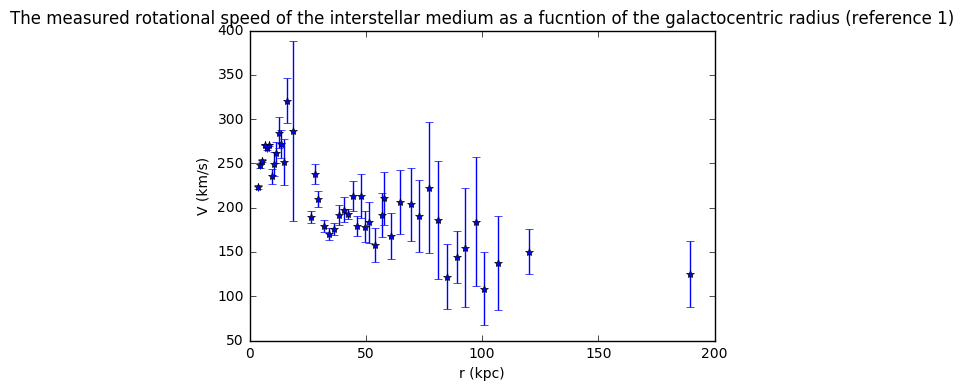

In [9]:
data_xerr = 0
plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
plt.show()

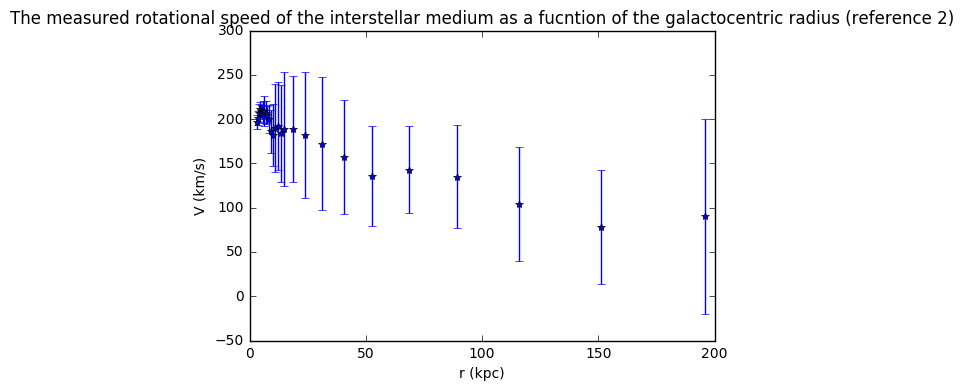

In [10]:
data_xerr = 0
plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
plt.show()

### The log likelihood is meant to capture how well a model is able to reproduce the data that it is meant to simulate.

$log p(D|M, I) = constant* \prod_{i}^{} log(\sigma_i)  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

$constant* \prod_{i}^{} log(\sigma_i) $, this part doesn't matter much since they are the same for all. 

$log p(D|M, I) =  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

## dark matter density model define 

In [11]:
# Define the model we use to describe the data.

def model_NFW(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))
        
    # Calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    # The units of sqrt(mass/x) are kpc.
    # The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, 
    # rho0 is the normalization constant of the mass distribution, and x is the distance at which we
    # calculate vrot.
    # When we determine theta[1], we determine sqrt(G*rho0).
    # The units of vrot are km/s.
    # The units of sqrt(mass/x) are kpc.
    # The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.
    # Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G.
    # The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3)
    # To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3
    # The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = 
    # (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    vrot = theta[1]*np.sqrt(mass/x) 
    
    return vrot

## define likelihood 

In [12]:
# Define a likelihood function
def loglike_NFW_ref1(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref1)/a)-data_x_ref1/(a+data_x_ref1))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref1) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.



In [13]:
# Define a likelihood function
def loglike_NFW_ref2(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref2)/a)-data_x_ref2/(a+data_x_ref2))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref2) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.


## define prior 

In [14]:
# It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 
# 


def prior_transform_NFW(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([20, 300]) * theta
    #return  np.array([10*theta[0],500*theta[1]])


Therefore, we can calculated the posterior $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $ and compare the posterior by MCMC and/or Nestle to do model comparison. 

By using the Nestle package, it will give us log evidence, numerical (sampling) error on logz, array of sample parameters, array of weights associated with each sampleand result.weights. 

In [15]:
# Run nested sampling.

# Start with reference 1

result_ref1 = nestle.sample(loglike_NFW_ref1, prior_transform_NFW, 2)

print ('Number of iterations for Data in Reference 1')
print (result_ref1.niter)

print ('log evidence for Data in Reference 1')
print (result_ref1.logz)

print ('numerical (sampling) error on logz for Data in Reference 1')
print (result_ref1.logzerr)   
       
print ('array of sample parameters for Data in Reference 1')
print (result_ref1.samples)  
       
#print ('array of weights associated with each sample for Data in Reference 1')
#print (result_ref1.weights)

# Continue with reference 2

result_ref2 = nestle.sample(loglike_NFW_ref2, prior_transform_NFW, 2)

print ('Number of iterations for Data in Reference 2')
print (result_ref2.niter)

print ('log evidence for Data in Reference 2')
print (result_ref2.logz)

print ('numerical (sampling) error on logz for Data in Reference 2')
print (result_ref2.logzerr)   
       
print ('array of sample parameters for Data in Reference 2')
print (result_ref2.samples)  
       
#print ('array of weights associated with each sample for Data in Reference 2')
#print (result_ref2.weights)


Number of iterations for Data in Reference 1
1243
log evidence for Data in Reference 1
-280.873101867
numerical (sampling) error on logz for Data in Reference 1
0.32339088572486957
array of sample parameters for Data in Reference 1
[[  19.87884127  283.39842286]
 [  17.51625594  283.49173726]
 [  18.33441052  260.82033837]
 ..., 
 [   3.34531639   48.40657278]
 [   3.38325476   47.7928998 ]
 [   3.38360649   47.87083616]]
Number of iterations for Data in Reference 2
851
log evidence for Data in Reference 2
-8.72578065741
numerical (sampling) error on logz for Data in Reference 2
0.25929452809348263
array of sample parameters for Data in Reference 2
[[  15.72112324  298.08823542]
 [  17.74503977  262.54424098]
 [  15.59291159  282.93133512]
 ..., 
 [   2.49068123   50.17278493]
 [   2.29671344   54.17494023]
 [   2.89071493   43.67623494]]


## call Nestle 

Results based on fits to the data from reference 1:
Core radius a =  3.31 +/-  0.11 kpc
Normalization factor = 49.01 +/-  1.63
Halo density normalization constant = 1.13e+07 +/- 3.78e+05 Msun/kpc^3
Halo density in our solor system = 6.17e+07 Msun/kpc^3.
Halo density in our solor system = 2.35e+03 GeV/c^2/liter.


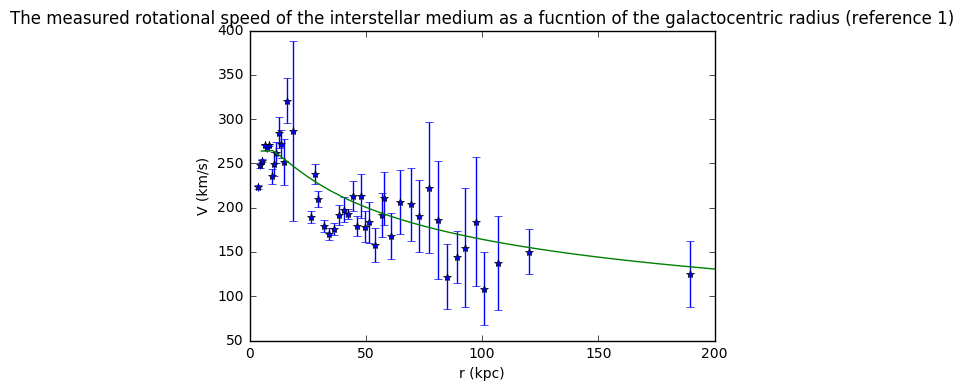

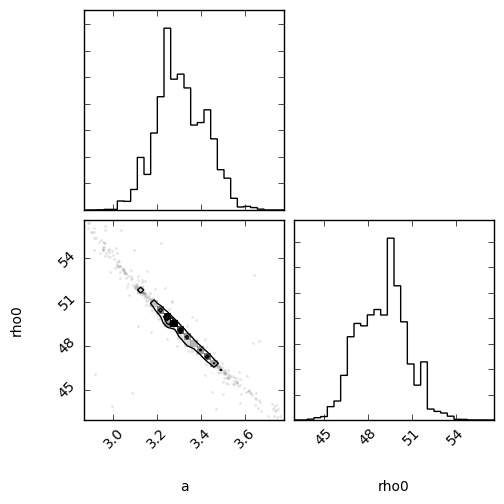

Results based on fits to the data from reference 1:
Core radius a =  2.53 +/-  0.54 kpc
Normalization factor = 52.02 +/- 11.09
Halo density normalization constant = 1.20e+07 +/- 2.56e+06 Msun/kpc^3
Halo density in our solor system = 4.95e+07 Msun/kpc^3.
Halo density in our solor system = 1.89e+03 GeV/c^2/liter.


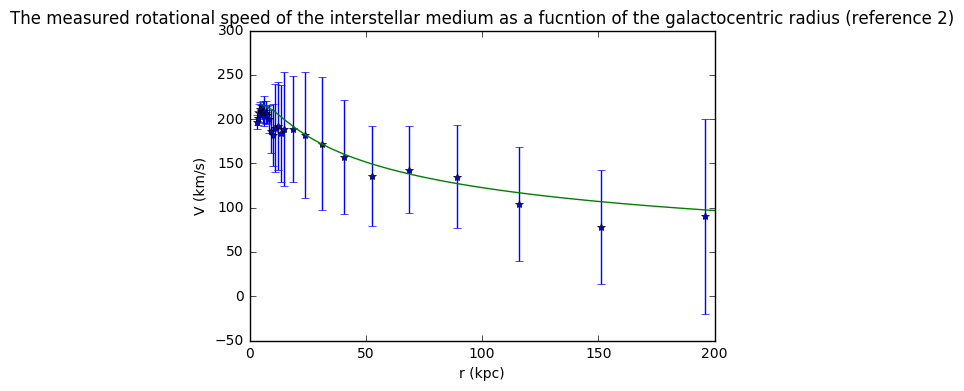

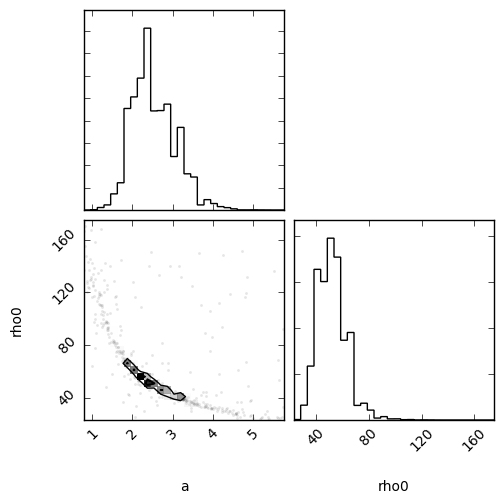

In [16]:
data_xerr = 0

# Get the results of the fit and the uncertainties in the fit parameters.
p_ref1, cov_ref1 = nestle.mean_and_cov(result_ref1.samples, result_ref1.weights)
p_ref2, cov_ref2 = nestle.mean_and_cov(result_ref2.samples, result_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref1[0], np.sqrt(cov_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref1[1], np.sqrt(cov_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref1[1], 2.312E5*np.sqrt(cov_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_ref1, xplot))
plt.show()

fig = corner.corner(result_ref1.samples, weights=result_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref2[0], np.sqrt(cov_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref2[1], np.sqrt(cov_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref2[1], 2.312E5*np.sqrt(cov_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_ref2, xplot))
plt.show()

fig = corner.corner(result_ref2.samples, weights=result_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

### Reference
[1] J. H. Oort. The force exerted by the stellar system in the direction perpendicular to the galactic plane and some related problems. Bull. Astr. Inst. Netherlands, 6:249, aug 1932.

[2] D. P. Clemens. Massachusetts-Stony Brook Galactic plane CO survey - The Galactic disk rotation curve. Astrophys. J. , 295:422–428, August 1985.

[3] V. C. Rubin, N. Thonnard, and W. K. Ford, Jr. Extended rotation curves of high-luminosity spiral galaxies. IV - Systematic dynamical properties, SA through SC. The Astrophysical Journal, 225:L107–L111, November 1978.

[4] F. Zwicky. Die Rotverschiebung von extragalaktischen Nebeln. Helvetica Physica Acta, 6:110–127, 1933.

[5] Douglas Clowe, Marusa Bradac, Anthony H. Gonzalez, Maxim Markevitch, Scott W. Randall, Christine Jones, and Dennis Zaritsky. A direct empirical proof of the existence of dark matter. Astrophys. J., 648:L109–L113, 2006.

[6] Maxim Markevitch. Chandra observation of the most interesting cluster in the universe. 2005. [ESA Spec. Publ.604,723(2006)].

[7] Composite Credit: X-ray: NASA/CXC/CfA/ M.Markevitch et al.; Lensing Map: NASA/STScI; ESO WFI; Magellan/ U.Arizona/ D.Clowe et al.; Optical: NASA/STScI; Magellan/ U.Arizona/D.Clowe et al.;.

[8] Pijushpani Bhattacharjee, Soumini Chaudhury, and Susmita Kundu. Rotation Curve of the Milky Way out to 200 kpc. Astrophys. J., 785:63, 2014.